# Metodos de separación ciega de señales aplicado a videos

Recupera los metodos que funcionan del notebook anterior:
    
    - FCA fast para un frame con pre procesamiento
    
    - FCA fast para una cuadricula 2x2 con pre procesamiento
    
    - OVFCA fast para una cuadricula 2x2 con pre procesamiento

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
import itertools
import scipy.linalg 
from scipy.optimize import minimize

In [2]:
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, parent_dir)

from BSS import FCA_fast, OVFCA_fast, unmixing_error

In [3]:
from funciones_auxiliares import read_video_frames_and_format, transform_frames_2_grayscale, process_frames_video, mezclar_videos, concatenate_videos, procesar_videos_color, procesar_video_color 

In [4]:
folder_videos = "../Videos_originales/"

video1_path = folder_videos + "v1.mp4"
video2_path = folder_videos + "v2.mp4"
video3_path = folder_videos + "v3.mp4"

N = 100
frame_size = (N, N)
number_of_frames = 100
number_of_frames = 603

# Leer videos

In [5]:
# read videos with same same and number of frames
video1_frames_color = read_video_frames_and_format(video1_path, size = frame_size, target_frames = number_of_frames)
video2_frames_color = read_video_frames_and_format(video2_path, size = frame_size, target_frames = number_of_frames)
video3_frames_color = read_video_frames_and_format(video3_path, size = frame_size, target_frames = number_of_frames)
# sample the video 4  (uniform distribution)
noise = np.random.randint(0, 256, video1_frames_color.shape[:-1], dtype=np.uint8)
noise_3 = np.array([noise, noise, noise])
video4_frames_color = np.transpose(noise_3, (1, 2, 3, 0))
print(f"Shape of noise video: {video4_frames_color.shape}")

Original video:
Total number of frames: 603
Frame shape: (720, 720)

New frames shape: (603, 100, 100, 3)
--------------------------------------------------
Original video:
Total number of frames: 603
Frame shape: (720, 720)

New frames shape: (603, 100, 100, 3)
--------------------------------------------------
Original video:
Total number of frames: 603
Frame shape: (720, 720)

New frames shape: (603, 100, 100, 3)
--------------------------------------------------
Shape of noise video: (603, 100, 100, 3)


In [6]:
# transform the videos to grayscale
video1_frames = transform_frames_2_grayscale(video1_frames_color)
video2_frames = transform_frames_2_grayscale(video2_frames_color)
video3_frames = transform_frames_2_grayscale(video3_frames_color)
video4_frames = transform_frames_2_grayscale(video4_frames_color)

Original shape: (603, 100, 100, 3)
Grayscale shape: (603, 100, 100)
--------------------------------------------------
Original shape: (603, 100, 100, 3)
Grayscale shape: (603, 100, 100)
--------------------------------------------------
Original shape: (603, 100, 100, 3)
Grayscale shape: (603, 100, 100)
--------------------------------------------------
Original shape: (603, 100, 100, 3)
Grayscale shape: (603, 100, 100)
--------------------------------------------------


In [7]:
# process (mean and variance)
video1_frames_processed = process_frames_video(video1_frames)
video2_frames_processed = process_frames_video(video2_frames)
video3_frames_processed = process_frames_video(video3_frames)
video4_frames_processed = process_frames_video(video4_frames)

In [8]:
# juntar distintdas versiones de los 4 videos
# cada uno es de la forma: (num_videos, num_frames_video, N, N, color_chanels)
videos_color = np.array([video1_frames_color, video2_frames_color, video3_frames_color, video4_frames_color])
videos = np.array([video1_frames, video2_frames, video3_frames, video4_frames])
videos_processed = np.array([video1_frames_processed, video2_frames_processed, video3_frames_processed, video4_frames_processed])

# ver formar
print(f"Shape videos (color): {videos_color.shape}")
print(f"Shape videos: {videos.shape}")
print(f"Shape videos (processed): {videos_processed.shape}")

Shape videos (color): (4, 603, 100, 100, 3)
Shape videos: (4, 603, 100, 100)
Shape videos (processed): (4, 603, 100, 100)


# Mix the videos

In [9]:
# delimitar matriz de mezcla
A = [[0.4, 0.65, -0.4, -0.8], [0.4, 0.4, -0.4, 0.9], [-0.4, -0.4, 0.6, 0.8], [0.7, 0.5, -0.5, -0.8]]
A = np.array(A)
A

array([[ 0.4 ,  0.65, -0.4 , -0.8 ],
       [ 0.4 ,  0.4 , -0.4 ,  0.9 ],
       [-0.4 , -0.4 ,  0.6 ,  0.8 ],
       [ 0.7 ,  0.5 , -0.5 , -0.8 ]])

In [10]:
# mezclar los videos en los distintos formatos
videos_color_mezcla = mezclar_videos(A, videos_color)
videos_mezcla = mezclar_videos(A, videos)
videos_processed_mezcla = mezclar_videos(A, videos_processed)

Shape original: (4, 603, 100, 100, 3)
Shape mixture: (4, 603, 100, 100, 3)
----------------------------------------
Shape original: (4, 603, 100, 100)
Shape mixture: (4, 603, 100, 100)
----------------------------------------
Shape original: (4, 603, 100, 100)
Shape mixture: (4, 603, 100, 100)
----------------------------------------


# Intentar estimar la matriz de mezcla


## Separar usando un solo frame

In [11]:
# obtener unos frames para hacer fca
idx_frame = 200   # funciona bien
# idx_frame = 300

In [12]:
# frames con pre-procesamiento

# obtener las señales originales (solo por visualizacion)
frame_x1_processed = videos_processed[0][idx_frame]
frame_x2_processed = videos_processed[1][idx_frame]
frame_x3_processed = videos_processed[2][idx_frame]
frame_x4_processed = videos_processed[3][idx_frame]
señales_originales_x_processed = [frame_x1_processed, frame_x2_processed, frame_x3_processed, frame_x4_processed]

# obtener las señales mezcladas (para aplicar fca)
frame_y1_processed = videos_processed_mezcla[0][idx_frame]
frame_y2_processed = videos_processed_mezcla[1][idx_frame]
frame_y3_processed = videos_processed_mezcla[2][idx_frame]
frame_y4_processed = videos_processed_mezcla[3][idx_frame]
señales_y_processed = [frame_y1_processed, frame_y2_processed, frame_y3_processed, frame_y4_processed]

### FCA

In [13]:
start_time = time.time()

# ejecutar FCA
fca = FCA_fast(señales_y_processed)
fca.separar_señaes(repeticiones_optimizacion = 1, iniciar_W_ortogonal = True)
elapsed_time = time.time() - start_time

print(f"Ejecucion duro {elapsed_time} segundos")

C:\Users\diego\anaconda3\envs\ds\Lib\site-packages\scipy\optimize\_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Ejecucion duro 3.0515334606170654 segundos


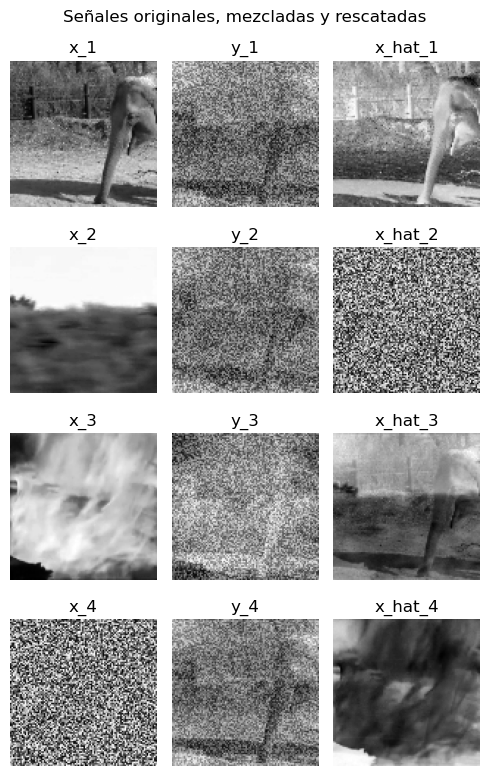

In [14]:
# ver el resultado
fca.ver(señales_x_originales = señales_originales_x_processed, figsize = (5, 8))

In [15]:
# salvar la matriz estimada por este metodo
A_hat_fca_single = fca.A_hat
A_hat_inv_fca_single = fca.A_hat_inversa

## Separar usando varios frames en cuadricula

In [16]:
def contruir_imagen_4_frames(frames_video, indices):
    """
    Dados muchos frames de un video, e indices de 4 frames
    Contruir una matriz que se componga de 4 bloques
    """
    
    # definir los bloques
    block11 = frames_video[indices[0]]
    block12 = frames_video[indices[1]]
    block21 = frames_video[indices[2]]
    block22 = frames_video[indices[3]]
    
    return np.block([[block11, block12], [block21, block22]])

In [17]:
# obtener 4 frames
indices_frames = [10, 200, 400, 600] # funciona bien
# indices_frames = [20, 210, 410, 610]

In [18]:
# frames con pre-procesamiento

# obtener las señales originales (solo por visualizacion)
frame_x1_processed = contruir_imagen_4_frames(videos_processed[0], indices_frames)
frame_x2_processed = contruir_imagen_4_frames(videos_processed[1], indices_frames)
frame_x3_processed = contruir_imagen_4_frames(videos_processed[2], indices_frames)
frame_x4_processed = contruir_imagen_4_frames(videos_processed[3], indices_frames)
señales_originales_x_processed = [frame_x1_processed, frame_x2_processed, frame_x3_processed, frame_x4_processed]

# obtener las señales mezcladas (para separar)
frame_y1_processed = contruir_imagen_4_frames(videos_processed_mezcla[0], indices_frames)
frame_y2_processed = contruir_imagen_4_frames(videos_processed_mezcla[1], indices_frames)
frame_y3_processed = contruir_imagen_4_frames(videos_processed_mezcla[2], indices_frames)
frame_y4_processed = contruir_imagen_4_frames(videos_processed_mezcla[3], indices_frames)
señales_y_processed = [frame_y1_processed, frame_y2_processed, frame_y3_processed, frame_y4_processed]

### FCA

In [19]:
start_time = time.time()

# ejecutar FCA
fca = FCA_fast(señales_y_processed)
fca.separar_señaes(repeticiones_optimizacion = 1, iniciar_W_ortogonal = True)
elapsed_time = time.time() - start_time

print(f"Ejecucion duro {elapsed_time} segundos")

Ejecucion duro 3.744574546813965 segundos


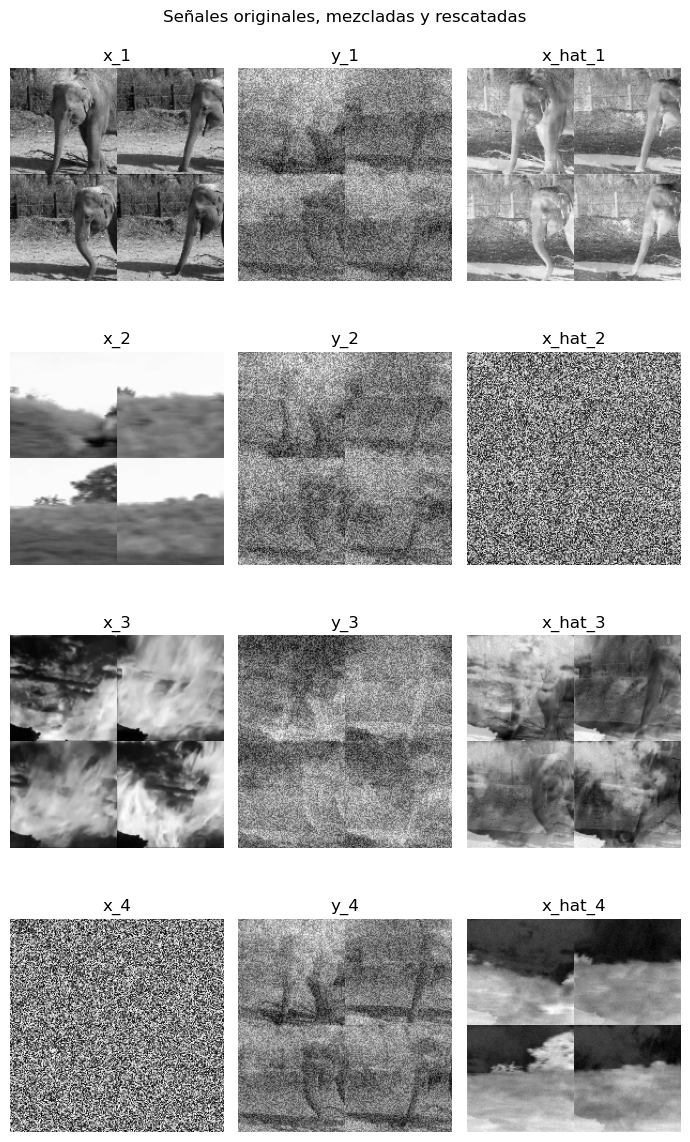

In [20]:
# ver el resultado
fca.ver(señales_x_originales = señales_originales_x_processed, figsize = (7, 12))

In [21]:
# salvar la matriz estimada por este metodo
A_hat_fca_grid = fca.A_hat
A_hat_inv_fca_grid = fca.A_hat_inversa

### OVFCA

In [22]:
def esperanza_condicional(A):
    N = A.shape[0] // 2  # Se asume que A es de tamaño 2N x 2N
    indices = [slice(0, N), slice(N, 2*N)]  # Definir índices para los bloques
    # Calcular trazas de los 4 bloques
    traces = np.array([[A[i, j].trace() for j in indices] for i in indices]) / N
    # Construir el resultado usando np.kron para replicar los valores con la identidad
    return np.kron(traces, np.eye(N))

# considerar la norma de frobenius en la imagen de la esperanza condicional
def frobenius_norm(A):
    return np.linalg.norm(A, 'fro')

In [23]:
start_time = time.time()

# ejecutar OVFCA
ovfca = OVFCA_fast(señales_y_processed, esperanza_condicional_F = esperanza_condicional, norma_en_B = frobenius_norm)
ovfca.separar_señaes(repeticiones_optimizacion = 1, iniciar_W_ortogonal = True)
elapsed_time = time.time() - start_time

print(f"Ejecucion duro {elapsed_time} segundos")

Ejecucion duro 9.451863288879395 segundos


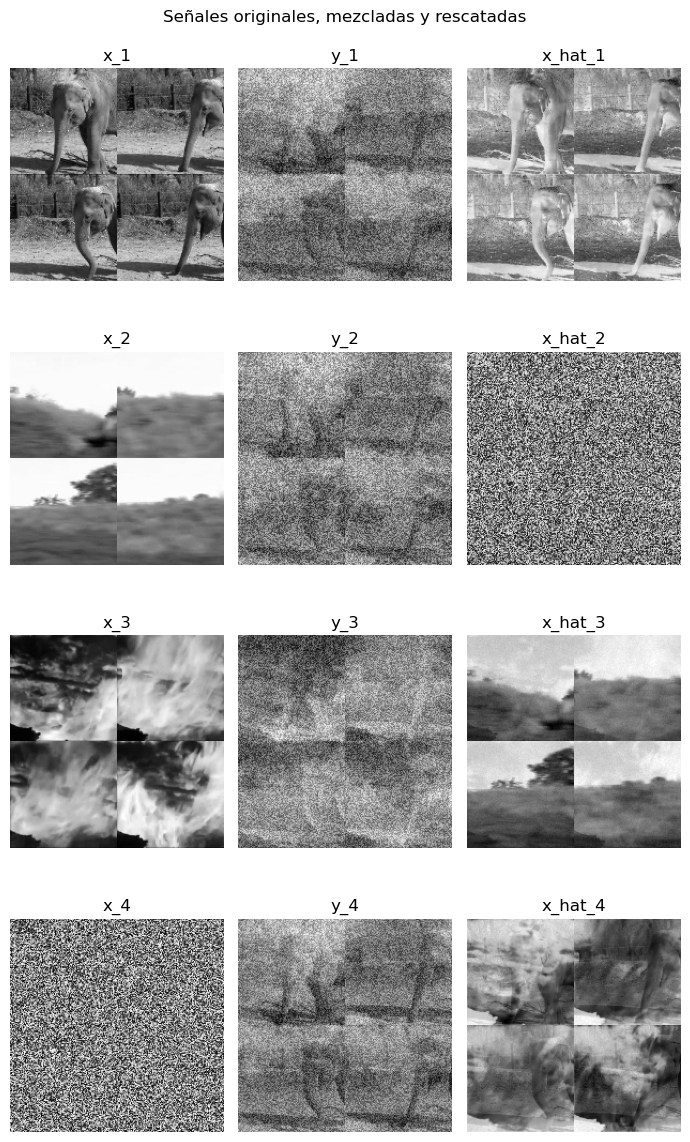

In [24]:
# ver el resultado
ovfca.ver(señales_x_originales = señales_originales_x_processed, figsize = (7, 12))

In [25]:
# salvar la matriz estimada por este metodo
A_hat_ovfca_grid = ovfca.A_hat
A_hat_inv_ovfca_grid = ovfca.A_hat_inversa

# Hacer la separacion del video a color

In [26]:
# obtener estimaciones de las señales originales
videos_color_hat_fca_single = mezclar_videos(A_hat_inv_fca_single, videos_color_mezcla)
videos_color_hat_fca_grid = mezclar_videos(A_hat_inv_fca_grid, videos_color_mezcla)
videos_color_hat_ovfca_grid = mezclar_videos(A_hat_inv_ovfca_grid, videos_color_mezcla)

Shape original: (4, 603, 100, 100, 3)
Shape mixture: (4, 603, 100, 100, 3)
----------------------------------------
Shape original: (4, 603, 100, 100, 3)
Shape mixture: (4, 603, 100, 100, 3)
----------------------------------------
Shape original: (4, 603, 100, 100, 3)
Shape mixture: (4, 603, 100, 100, 3)
----------------------------------------


In [27]:
# CAMBIOS DE SIGNOS MANUALES, PARA MEJOR VISUALIZACION

videos_color_hat_fca_single[0] *= -1
videos_color_hat_fca_single[1] *= 1
videos_color_hat_fca_single[2] *= -1
videos_color_hat_fca_single[3] *= 1

videos_color_hat_fca_grid[0] *= -1
videos_color_hat_fca_grid[1] *= 1
videos_color_hat_fca_grid[2] *= 1
videos_color_hat_fca_grid[3] *= -1

videos_color_hat_ovfca_grid[0] *= -1
videos_color_hat_ovfca_grid[1] *= 1
videos_color_hat_ovfca_grid[2] *= -1
videos_color_hat_ovfca_grid[3] *= 1

In [28]:
# procesar videos para que se puedan ver correctamente
videos_color_mezcla_rgb = procesar_videos_color(videos_color_mezcla)
videos_color_hat_fca_single_rgb = procesar_videos_color(videos_color_hat_fca_single)
videos_color_hat_fca_grid_rgb = procesar_videos_color(videos_color_hat_fca_grid)
videos_color_hat_ovfca_grid_rgb = procesar_videos_color(videos_color_hat_ovfca_grid)

In [29]:
# hacer el video para fca_single
lista_videos_hat_fca_single = [videos_color, videos_color_mezcla_rgb, videos_color_hat_fca_single_rgb]
concatenate_videos(lista_videos_hat_fca_single, output_path = "../Videos_output/fca_single.mp4")

Video guardado en ../Videos_output/fca_single.mp4


In [30]:
# hacer el video para fca_grid
lista_videos_hat_fca_grid = [videos_color, videos_color_mezcla_rgb, videos_color_hat_fca_grid_rgb]
concatenate_videos(lista_videos_hat_fca_grid, output_path = "../Videos_output/fca_2x2_grid.mp4")

Video guardado en ../Videos_output/fca_2x2_grid.mp4


In [31]:
# hacer el video para ovfca_grid
lista_videos_hat_ovfca_grid = [videos_color, videos_color_mezcla_rgb, videos_color_hat_ovfca_grid_rgb]
concatenate_videos(lista_videos_hat_ovfca_grid, output_path = "../Videos_output/ovfca_2x2_grid.mp4")

Video guardado en ../Videos_output/ovfca_2x2_grid.mp4


# Evaluar el error de cada metodo


In [32]:
# ver los errores de los metodos considerados
error_fca_single = unmixing_error(A, A_hat_fca_single)
error_fca_grid = unmixing_error(A, A_hat_fca_grid)
error_ovfca_grid = unmixing_error(A, A_hat_ovfca_grid)

In [33]:
# mostrar
decimales = 3
print(f"Error FCA single: {round(error_fca_single, decimales)}")
print(f"Error FCA 2x2 grid: {round(error_fca_grid, decimales)}")
print(f"Error OVFCA 2x2 grid: {round(error_ovfca_grid, decimales)}")

Error FCA single: 0.497
Error FCA 2x2 grid: 0.58
Error OVFCA 2x2 grid: 0.535
